# Práctica. Clasificador de autoría
## Grupo 6BM1

* Integrantes:
* Carmona Serrano Ian Carlo
* Mendez López Luz Fernanda 

Importamos las Librerias

In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
import string
from collections import defaultdict
import nltk
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


Leemos el archivo xlsx y lo pasamos a csv

In [34]:
archivo_xlsx = './datasets/dataP3/dataFrases.xlsx'
datos_xlsx = pd.read_excel(archivo_xlsx)
archivo_csv = './datasets/dataP3/dataFrases.csv'
datos_xlsx.to_csv(archivo_csv, index=False)
print(f'Se ha guardado el archivo CSV: {archivo_csv}')

# Vamos a leer el dataset guardado para utilizarlo en el codigo

df = pd.read_csv('./datasets/dataP3/dataFrases.csv')

df['frase'] = df['frase'].str.lower()
df['frase'] = df['frase'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

df.head()

Se ha guardado el archivo CSV: ./datasets/dataP3/dataFrases.csv


,frase,clase
0,de vuelta a cuando encajabas en mis poemas com...,Autor
1,el resto del mundo estaba en blanco y negro pe...,Autor
2,porque de los peores hombres es de los que mej...,Autor
3,todas mis mañanas son lunes atrapados en un fe...,Autor
4,podría construir un castillo con todos los lad...,Autor


Aqui sacaremos las 10 palabras utilizadas del autor para realizar la distribucion de frecuencias

In [35]:
stop_words = set(stopwords.words('spanish'))

def tokenize(texto):
    stop_words = set(stopwords.words('spanish'))
    palabras = word_tokenize(texto, language='spanish')
    palabras_filtradas = [palabra.lower() for palabra in palabras if palabra.isalnum() and palabra.lower() not in stop_words and len(palabra) > 3]
    return palabras_filtradas

datos_autor = df[df['clase'] == 'Autor']
textos_autor = datos_autor['frase']

# Inicializa el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize)
tfidf_matrix = tfidf_vectorizer.fit_transform(textos_autor)
nombres_palabras = tfidf_vectorizer.get_feature_names_out()
tfidf_promedio = tfidf_matrix.mean(axis=0)
tfidf_promedio_arr = tfidf_promedio.A1
df_tfidf = pd.DataFrame({'Palabra': nombres_palabras, 'TF-IDF Promedio': tfidf_promedio_arr})
df_tfidf_ordenado = df_tfidf.sort_values(by='TF-IDF Promedio', ascending=False)

print("Las 10 palabras más importantes en la clase 'Autor':")
print(df_tfidf_ordenado.head(10))

palabras_importantes_autor = df_tfidf_ordenado['Palabra'].head(10).values

Las 10 palabras más importantes en la clase 'Autor':
       Palabra  TF-IDF Promedio
395      puedo         0.023432
10       ahora         0.020680
461     tiempo         0.019819
332      nunca         0.018217
145  diferente         0.013643
442     sentir         0.012651
23        amor         0.012648
93     corazón         0.012576
282       loco         0.012489
128  demasiado         0.012463


c:\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Realizaremos en este fragmento de codigo la distribucion de frecuencia y guardaremos estas frecuencias de cada frase en un arreglo


In [36]:
distribucion_frecuencia_vc = []

for frase in df['frase']:
    palabras_frase = frase.split()
    conteo = sum(1 for palabra in palabras_frase if palabra in palabras_importantes_autor)
    distribucion_frecuencia_vc.append(conteo)

print(distribucion_frecuencia_vc)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 1, 3, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Ahora calcularemos el vector de caracterizticas de tamaño que se realizara contando cuantas palabras tiene cada frase

In [37]:
tamaño_vc = []

for frase in df['frase']:
    palabras_frase = frase.split()
    tamaño_vc.append(len(palabras_frase))

print(tamaño_vc)

[12, 15, 11, 10, 11, 10, 24, 16, 11, 24, 7, 10, 11, 7, 15, 13, 18, 7, 17, 8, 8, 13, 18, 12, 7, 10, 26, 19, 12, 16, 16, 17, 7, 14, 18, 22, 12, 13, 14, 13, 14, 14, 15, 15, 22, 13, 25, 13, 12, 14, 23, 20, 19, 12, 16, 19, 16, 21, 10, 12, 11, 21, 9, 13, 17, 16, 9, 10, 16, 4, 15, 3, 9, 21, 28, 11, 14, 12, 14, 11, 12, 9, 10, 9, 15, 9, 19, 23, 21, 20, 21, 9, 7, 23, 11, 14, 15, 9, 9, 14, 12, 14, 10, 11, 13, 26, 21, 9, 19, 15, 11, 18, 15, 14, 9, 8, 20, 8, 17, 6, 14, 22, 17, 10, 9, 10, 18, 19, 7, 11, 9, 26, 12, 8, 11, 10, 15, 13, 13, 10, 10, 7, 13, 9, 10, 13, 13, 11, 14, 11, 9, 9, 12, 14, 29, 14, 11, 10, 12, 18, 8, 19, 17, 13, 29, 8, 11, 16, 20, 14, 22, 14, 17, 22, 10, 14, 9, 7, 11, 7, 26, 10, 14, 14, 21, 11, 15, 33, 7, 17, 13, 20, 6, 5, 9, 20, 4, 23, 19, 14]


Realizaremos la funcion para calcular N-gramas tradicionales

In [38]:
def calcular_frecuencia_ngramas(texto, n):
    ngramas = defaultdict(int)
    palabras = texto.split()
    for i in range(len(palabras)-n+1):
        ngrama = ' '.join(palabras[i:i+n])
        ngramas[ngrama] += 1
    return ngramas

Ahora realizaremos el calculo de N-gramamas tradicionales para nuestro vector de caracteristicas

In [39]:
# Definir el valor de N para nuestro N-grama
N = 2

ngramas_por_frase = []

# Calcular los N-gramas para cada frase en el dataset
for frase in df['frase']:
    ngramas_frase = calcular_frecuencia_ngramas(frase, N)
    #print(ngramas_frase)
    # Calcular el promedio de las frecuencias de los N-gramas
    promedio_ngramas = sum(ngramas_frase.values()) / len(ngramas_frase)
    ngramas_por_frase.append(promedio_ngramas)
    
print(ngramas_por_frase)

[1.0, 1.0, 1.1111111111111112, 1.0, 1.0, 1.0, 1.0952380952380953, 1.0714285714285714, 1.0, 1.0, 1.0, 1.0, 1.1111111111111112, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.05, 1.0909090909090908, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1538461538461537, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0769230769230769, 1.0, 1.0, 1.0, 1.08, 1.0, 1.1818181818181819, 1.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0526315789473684, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1428571428571428, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0416666666666667, 1.0, 1.0, 1.0588235294117647, 1.0769230769230769, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0666666666666667, 1.0, 1.1818181818181819, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.6666666666666667, 1.0, 1.0, 1.0, 1.0, 1.1666666666666667, 1.2, 1.0, 1.2857142857142858, 1.0, 1.0, 1.

Hacemos la funcion para calcular N-gramas sintacticos

In [40]:
def calcular_frecuencia_ngramas_sintacticos(frase):
    ngramas_sintacticos = defaultdict(int)
    palabras = nltk.word_tokenize(frase)
    tags = nltk.pos_tag(palabras)
    for i in range(len(tags)):
        etiqueta = tags[i][1]  # Obtiene la etiqueta sintáctica de la palabra
        ngramas_sintacticos[etiqueta] += 1
    return ngramas_sintacticos

Ahora realizaremos el calculo de N-gramamas sintacticos para nuestro vector de caracteristicas

In [41]:
ngramas_sintacticos_por_frase = []

# Calcular los N-gramas sintácticos para cada frase en el dataset
for frase in df['frase']:
    ngramas_sintacticos_frase = calcular_frecuencia_ngramas_sintacticos(frase)
    #print(ngramas_sintacticos_frase)
    # Calcular el promedio de las frecuencias de los N-gramas sintácticos
    promedio_ngramas_sintacticos = sum(ngramas_sintacticos_frase.values()) / len(ngramas_sintacticos_frase)
    ngramas_sintacticos_por_frase.append(promedio_ngramas_sintacticos)
    
print(ngramas_sintacticos_por_frase)

[2.4, 2.5, 1.8333333333333333, 2.0, 2.75, 2.5, 4.8, 2.2857142857142856, 2.2, 4.0, 3.5, 3.3333333333333335, 2.2, 2.3333333333333335, 3.0, 2.6, 3.6, 2.3333333333333335, 2.4285714285714284, 4.0, 1.6, 1.625, 6.0, 3.0, 3.5, 2.5, 3.25, 3.8, 1.5, 2.0, 2.6666666666666665, 2.4285714285714284, 2.3333333333333335, 3.5, 3.6, 3.6666666666666665, 3.0, 3.25, 2.8, 4.333333333333333, 2.3333333333333335, 2.8, 3.0, 3.0, 3.142857142857143, 2.6, 5.0, 2.1666666666666665, 6.0, 3.5, 4.6, 3.3333333333333335, 2.111111111111111, 4.0, 3.2, 3.1666666666666665, 2.2857142857142856, 3.0, 3.3333333333333335, 3.0, 3.6666666666666665, 2.625, 2.25, 1.625, 1.8888888888888888, 2.2857142857142856, 2.25, 10.0, 2.2857142857142856, 2.0, 2.5, 3.0, 4.5, 3.0, 4.666666666666667, 2.2, 3.5, 3.0, 2.8, 3.6666666666666665, 1.7142857142857142, 4.5, 3.3333333333333335, 3.0, 2.142857142857143, 4.5, 3.8, 4.6, 5.25, 3.3333333333333335, 2.625, 4.5, 3.5, 4.6, 2.75, 4.666666666666667, 3.75, 2.25, 2.25, 3.5, 2.4, 2.8, 1.6666666666666667, 2.2, 3

Ahora haremos la vectorizacion de nuestras frases con word2vec

In [42]:

df['tokenized_frase'] = df['frase'].apply(word_tokenize)

model = Word2Vec(df['tokenized_frase'], vector_size=100, window=5, min_count=1, workers=4)

# Obtener el embedding para cada palabra en cada frase y calcular el promedio
embeddings_por_frase = []
for tokenized_frase in df['tokenized_frase']:
    frase_embedding = []
    for palabra in tokenized_frase:
        if palabra in model.wv.key_to_index:
            palabra_embedding = model.wv[palabra]
            frase_embedding.append(palabra_embedding)
    # Calcular el promedio de los embeddings de palabras en la frase
    if frase_embedding:
        promedio_embedding_frase = sum(frase_embedding) / len(frase_embedding)
        embeddings_por_frase.append(promedio_embedding_frase)
    else:
        embeddings_por_frase.append(None)

print(embeddings_por_frase)

[array([ 1.7536767e-03,  1.3328972e-04,  3.4196998e-03,  3.2075562e-03,
       -7.7290420e-04, -2.8909806e-03,  2.3267912e-03,  5.0167651e-03,
       -2.5339269e-03, -2.5292896e-03, -1.9416403e-03, -5.1435116e-03,
        2.7304707e-04,  1.7798642e-03,  1.1267981e-04,  5.0589995e-04,
        1.9964708e-03,  1.4985062e-04, -8.4012871e-05, -3.4874296e-03,
        2.3954762e-03, -6.9790450e-04,  2.7603849e-03, -5.3866957e-03,
        3.7586689e-04,  2.5729958e-03, -3.5484182e-03, -3.0794411e-03,
       -2.6158548e-03, -9.0767433e-05,  4.2330753e-03, -2.6451368e-04,
        2.1025725e-03, -3.3538910e-03, -9.9164294e-04,  7.2616403e-04,
        3.7181906e-03,  1.8705552e-03,  1.1956911e-03, -2.1115497e-03,
        1.4087119e-03, -5.8112871e-03, -1.3321001e-03,  2.0741420e-03,
        4.4598713e-04, -1.9688513e-03, -1.4357460e-03, -8.3658943e-04,
        2.7168402e-03,  1.8992106e-03, -1.8467266e-03, -4.4463887e-03,
       -1.1935154e-03,  5.7671900e-04, -3.0430383e-04,  4.0973644e-03,
     

Ahora todos los vectores de caracteristicas que calculamos los vamos a agregar al vector de word2vec

In [43]:
# Crear una nueva lista para almacenar los embeddings combinados
embeddings_combinados = []

for idx, embedding in enumerate(embeddings_por_frase):
    if embedding is not None:
        # Convertir el embedding a una lista y agregar las características adicionales
        embedding_lista = embedding.tolist()
        embedding_lista.append(distribucion_frecuencia_vc[idx])
        embedding_lista.append(tamaño_vc[idx])
        embedding_lista.append(ngramas_sintacticos_por_frase[idx])
        embedding_lista.append(ngramas_por_frase[idx])
        # Convertir la lista de nuevo a un array de numpy y agregarla a la lista de embeddings combinados
        embeddings_combinados.append(np.array(embedding_lista))
    else:
        # Si el embedding es None, agregar un vector de ceros con la longitud adecuada
        embedding_lista = [0] * (model.vector_size + 4)
        embeddings_combinados.append(np.array(embedding_lista))

#print(embeddings_combinados[1]) 

### Parte dos: Implementacion del clasificador


utilizando maquinas de soporte vectorial con word2vec

antes utilizamos randomforest pero para este caso salia peor

Accuracy: 0.675
              precision    recall  f1-score   support

       Autor       0.88      0.37      0.52        19
    No autor       0.62      0.95      0.75        21

    accuracy                           0.68        40
   macro avg       0.75      0.66      0.64        40
weighted avg       0.74      0.68      0.64        40



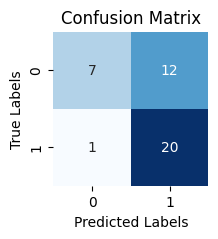

In [44]:
X = embeddings_combinados
y = df['clase']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest
rf_clf = SVC(kernel='linear', random_state=42)
rf_clf.fit(X_train, y_train)

# Predecir las etiquetas en el conjunto de prueba
y_pred = rf_clf.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

# Añadir etiquetas y título
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Mostrar el mapa de calor
plt.show()

probaremos ahora un nuvo enfoce con una vectorizacion con tfidf y randomforest 

aqui igual lo probamos con SVM pero ganaba randomforest

1003
Combined Accuracy: 1.0
              precision    recall  f1-score   support

       Autor       0.93      0.68      0.79        19
    No autor       0.77      0.95      0.85        21

    accuracy                           0.82        40
   macro avg       0.85      0.82      0.82        40
weighted avg       0.84      0.82      0.82        40



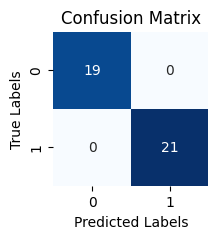

In [45]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['frase'])

additional_features = np.array([distribucion_frecuencia_vc, tamaño_vc, ngramas_sintacticos_por_frase, ngramas_por_frase]).T

# Combinar las características de TF-IDF con las características adicionales
X_combined = np.hstack((X.toarray(), additional_features))
print(len(X_combined[1]))

# Dividir los datos combinados en conjuntos de entrenamiento y prueba
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest con las características combinadas
rf_clf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_combined.fit(X_train_combined, y_train_combined)

# Predecir las etiquetas en el conjunto de prueba combinado
y_pred_combined = rf_clf_combined.predict(X_test_combined)

# Evaluar el rendimiento del modelo combinado
accuracy_combined = accuracy_score(y_test_combined, y_test_combined)
print(f'Combined Accuracy: {accuracy_combined}')
print(classification_report(y_test_combined, y_pred_combined))


conf_matrix = confusion_matrix(y_test_combined, y_test_combined)

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

# Añadir etiquetas y título
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Mostrar el mapa de calor
plt.show()


Guardamos los modelos

In [46]:
# Guardar el modelo entrenado
joblib.dump(rf_clf_combined, 'modelo_rf.pkl')

# Guardar el vectorizador TF-IDF
joblib.dump(vectorizer, 'vectorizador_tfidf.pkl')

# Guardar los otros objetos necesarios
np.save('distribucion_frecuencia_vc.npy', distribucion_frecuencia_vc)
np.save('tamaño_vc.npy', tamaño_vc)
np.save('ngramas_sintacticos_por_frase.npy', ngramas_sintacticos_por_frase)
np.save('ngramas_por_frase.npy', ngramas_por_frase)

En esta parte del codigo vamos a preguntarle al usuraio una frase y se la vamos a pasar al modelo para que prediga

In [47]:
def calcular_distribucion_frecuencias_una_frase(frase):
    palabras_frase = frase.split()
    conteo = sum(1 for palabra in palabras_frase if palabra in palabras_importantes_autor)
    return conteo

def calcular_tamaño_una_frase(frase):
    palabras_frase = frase.split()
    return len(palabras_frase)

def calcular_ngrama_t_una_frase(frase):
    ngramas_frase = calcular_frecuencia_ngramas(frase, N)
    promedio_ngramas = sum(ngramas_frase.values()) / len(ngramas_frase)
    return promedio_ngramas
    
def calcular_ngrama_s_una_frase(frase):
    ngramas_sintacticos_frase = calcular_frecuencia_ngramas_sintacticos(frase)
    promedio_ngramas_sintacticos = sum(ngramas_sintacticos_frase.values()) / len(ngramas_sintacticos_frase)
    return promedio_ngramas_sintacticos

Prdecimos el texto introducido 

In [71]:
# Cargar el modelo entrenado y el vectorizador TF-IDF
rf_clf_combined = joblib.load('modelo_rf.pkl')
vectorizer = joblib.load('vectorizador_tfidf.pkl')

# Nueva frase para probar el modelo
nueva_frase = input("Ingrese su nueva frase: ")

# Vectorizar la nueva frase
X_nueva = vectorizer.transform([nueva_frase])

# Calcular las características adicionales para la nueva frase
nueva_distribucion_frecuencia_vc = calcular_distribucion_frecuencias_una_frase(nueva_frase)
nuevo_tamaño_vc = calcular_tamaño_una_frase(nueva_frase)
nuevo_ngramas_sintacticos = calcular_ngrama_s_una_frase(nueva_frase)
nuevo_ngramas = calcular_ngrama_t_una_frase(nueva_frase)

# Combinar las características de TF-IDF con las características adicionales
nuevas_caracteristicas_adicionales = np.array([nueva_distribucion_frecuencia_vc, nuevo_tamaño_vc, nuevo_ngramas_sintacticos, nuevo_ngramas]).reshape(1, -1)
X_nueva_combined = np.hstack((X_nueva.toarray(), nuevas_caracteristicas_adicionales))

# Hacer la predicción
prediccion = rf_clf_combined.predict(X_nueva_combined)

if(prediccion == 'Autor'):
    print(f'La frase: ("{nueva_frase}") "SI" es de taylor swift')
else:
    print(f'La frase: {nueva_frase} "NO" es de taylor swift')


La frase: pues ya quedo "NO" es de taylor swift
